In [1]:
from copy import deepcopy as deepcopy

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import scipy as scipy
from plotly.subplots import make_subplots
from utils.ESN import ESN
from utils.input_signal_generator import generate_signal
from utils.split_data import split_data
from utils.van_der_pol_simulation import van_der_pol_oscillator

# Generate Training and Test Data

In [ ]:
# -----------------------------
# Generate input signal
# -----------------------------
config = {
    "segments": [
        {"type": "prbs", "points": 1000, "a_range": [0, 1], "b_range": [200, 300]},
        {"type": "prbs", "points": 500, "a_range": [0, 1], "b_range": [300, 800]},
        {"type": "constant", "value": 2.0, "points": 500},
        {"type": "prbs", "points": 1000, "a_range": [0, 1], "b_range": [500, 1000]},
        {"type": "constant", "value": 1.7, "points": 500},
        {"type": "prbs", "points": 2000, "a_range": [0, 1], "b_range": [500, 1000]},
    ]
}

u = generate_signal(config, seed=42)

# -----------------------------
# Run Van der Pol simulation
# -----------------------------
mu = 1.0
dt = 0.1
initial_state = (2.0, 2.0)

data = van_der_pol_oscillator(u, mu=mu, dt=dt, initial_state=initial_state)

# -----------------------------
# Split data for training and testing
# -----------------------------
train_data, test_data, u_train, u_test, Yt = split_data(
    data=data,
    u=u,
    train_size=500,
    test_size=5000,
    warm_up=100,
)

# ESN Training

In [50]:
train_size = 500
test_size = 5000
warm_up = 100

train_data_predictions = train_size - warm_up

# Initialize ESN
esn = ESN(
    input_size=1,
    output_size=2,
    train_size=500,
    test_size=5000,
    warm_up=100,
    random_seed=41,
    reservoir_size=100,
)

# Assign data using the provided function
esn.set_data(
    u_train=u_train, u_test=u_test, train_data=train_data, test_data=test_data, Yt=Yt
)

# Initialize weights
esn.generate_weights(
    spectral_radius=0.8,
    Win_scaling=0.15,
    Wf_scaling=0.15,
    Wb_scaling=0.0,
)

# Train and predict
esn.train_wout(leak_rate=1, reg=1e-4)
Y_pred = esn.predict(esn.Wout)


# PI-ESN

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import tensorflow_probability as tfp


class PIESN:
    def __init__(self, ESN, dt, cons_phy, colocation_points, subsampling):
        self.ESN = ESN
        self.PI_ESN = deepcopy(ESN)
        self.dt = dt
        self.cons_phy = cons_phy
        self.colocation_points = colocation_points
        self.subsampling = subsampling
        self.cost_data_list = []
        self.cost_physics_list = []
        self.output_prediction_PI = None
        self.MSE_list = []
        self.param_data_list = []
        self.param_phy_list = []

    def physical_regularization_vanderpol(self):
        def Wout_to_woutparam(Wout):
            # TRANSFORM THE 2D Wout array into 1D array for LBFGS FUNCTION
            Wout_1 = np.reshape(Wout[0, :], self.PI_ESN.reservoir_size)
            Wout_2 = np.reshape(Wout[1, :], self.PI_ESN.reservoir_size)
            Wout_param = np.hstack((Wout_1, Wout_2))  # initparam[0], initparam[1]))

            return Wout_param

        def woutparam_to_Wout(Wout_param):
            # TRANSFORM THE 1D Wout array into 2D array
            Wout = np.reshape(
                Wout_param[: int(self.PI_ESN.reservoir_size * self.PI_ESN.output_size)],
                (self.PI_ESN.output_size, self.PI_ESN.reservoir_size),
            )

            return Wout

        def loss_data(Wout_param):
            y1 = tf.linalg.matvec(
                self.PI_ESN.X_train.T, Wout_param[: self.PI_ESN.reservoir_size]
            )
            y2 = tf.linalg.matvec(
                self.PI_ESN.X_train.T,
                Wout_param[
                    self.PI_ESN.reservoir_size : int(self.PI_ESN.reservoir_size * 2)
                ],
            )

            cost_data_1 = (1 / (self.PI_ESN.train_size)) * tf.experimental.numpy.sum(
                (y1 - self.PI_ESN.Yt[0, :]) ** 2
            )
            cost_data_2 = (1 / (self.PI_ESN.train_size)) * tf.experimental.numpy.sum(
                (y2 - self.PI_ESN.Yt[1, :]) ** 2
            )
            cost_data = (cost_data_1 + cost_data_2) / 2

            return cost_data

        def loss_physics(Wout_param):
            u_data_phy = self.PI_ESN.input_data_test[
                :,
                : self.PI_ESN.test_size - 1,
            ]

            dt_phy = self.dt * self.subsampling

            y1 = tf.linalg.matvec(
                self.PI_ESN.X_test.T, Wout_param[: self.PI_ESN.reservoir_size]
            )
            y2 = tf.linalg.matvec(
                self.PI_ESN.X_test.T,
                Wout_param[
                    self.PI_ESN.reservoir_size : int(self.PI_ESN.reservoir_size * 2)
                ],
            )

            h1 = y1[: self.colocation_points - 1]
            h2 = y2[: self.colocation_points - 1]

            hn1 = y1[1 : self.colocation_points]
            hn2 = y2[1 : self.colocation_points]

            mu = 1

            cost_physics_1 = (h2 * dt_phy - hn1 + h1) ** 2
            cost_physics_2 = (
                (
                    -mu * (h1**2 - 1) * h2
                    - h1
                    + u_data_phy[0, : (self.colocation_points - 1)]
                )
                * dt_phy
                + h2
                - hn2
            ) ** 2

            cost_physics = tf.experimental.numpy.sum(
                cost_physics_1 + cost_physics_2
            ) / (self.PI_ESN.output_size * self.colocation_points)

            return cost_physics

        def cost_gradient(Wout_param):
            Wout_param = tf.Variable(Wout_param, trainable=True)

            with tf.GradientTape() as tape:
                cost_data = loss_data(Wout_param)
                self.cost_data_list.append(cost_data)
                cost_physics = loss_physics(Wout_param)
                self.cost_physics_list.append(cost_physics)

                # self adaptive loss
                # lambda1 = (1 / 2) * tf.math.exp(-Wout_param[-1])
                # lambda2 = (1 / 2) * tf.math.exp(-Wout_param[-2])

                cost = (
                    1 * cost_data + self.cons_phy * cost_physics
                    # + Wout_param[-1]
                    # + Wout_param[-2]
                )

                dcost = tape.gradient(cost, Wout_param)

                return cost, dcost

        def np_value(tensor):
            if isinstance(tensor, tuple):
                return type(tensor)(*(np_value(t) for t in tensor))
            else:
                return tensor.numpy()

        def run(optimizer):
            optimizer()  # Warmup.

            result = optimizer()

            return np_value(result)

        def cost_gradient_lbfgs():
            # init_param = [1, 1]
            init_value = Wout_to_woutparam(self.PI_ESN.Wout)  # ,init_param

            return tfp.optimizer.lbfgs_minimize(
                cost_gradient,
                initial_position=init_value,
                tolerance=1e-9,
                max_iterations=100,
                max_line_search_iterations=100,
            )

        for number_X_test_update in range(100):
            results = run(cost_gradient_lbfgs)
            theta = woutparam_to_Wout(results.position)
            self.PI_ESN.Wout = theta
            self.PI_ESN.predict(theta)

            MSE_1 = np.sum(
                ((theta @ self.PI_ESN.X_test)[0, :] - self.ESN.output_data_test[0, :])
                ** 2
            ) / (self.PI_ESN.test_size)
            MSE_2 = np.sum(
                ((theta @ self.PI_ESN.X_test)[1, :] - self.ESN.output_data_test[1, :])
                ** 2
            ) / (self.PI_ESN.test_size)
            MSE = (MSE_1 + MSE_2) / 2

            MSE_ESN_1 = np.sum(
                (
                    (self.ESN.Wout @ self.ESN.X_test)[0, :]
                    - self.ESN.output_data_test[0, :]
                )
                ** 2
            ) / (self.PI_ESN.test_size)
            MSE_ESN_2 = np.sum(
                (
                    (self.ESN.Wout @ self.ESN.X_test)[1, :]
                    - self.ESN.output_data_test[1, :]
                )
                ** 2
            ) / (self.PI_ESN.test_size)
            MSE_ESN = (MSE_ESN_1 + MSE_ESN_2) / 2

            self.MSE_list.append(MSE)
            print(
                "Epoch:",
                number_X_test_update,
                " error PI-ESN:",
                MSE,
                " error ESN:",
                MSE_ESN,
            )

        self.output_prediction_PI = theta @ self.PI_ESN.X_test

        return MSE

In [77]:
piesn = PIESN(esn, 0.1, 1e-3, 2000, 1)

In [78]:
MSE = piesn.physical_regularization_vanderpol()

Epoch: 0  error PI-ESN: 1.3139700658477658  error ESN: 1.7980125464535754
Epoch: 1  error PI-ESN: 1.3469340714128681  error ESN: 1.7980125464535754
Epoch: 2  error PI-ESN: 1.2466195377853087  error ESN: 1.7980125464535754
Epoch: 3  error PI-ESN: 1.2056768820926071  error ESN: 1.7980125464535754
Epoch: 4  error PI-ESN: 1.4520604811966877  error ESN: 1.7980125464535754
Epoch: 5  error PI-ESN: 1.1940925642846767  error ESN: 1.7980125464535754
Epoch: 6  error PI-ESN: 1.5217406518842727  error ESN: 1.7980125464535754
Epoch: 7  error PI-ESN: 1.381415521135101  error ESN: 1.7980125464535754
Epoch: 8  error PI-ESN: 1.6745102116862371  error ESN: 1.7980125464535754
Epoch: 9  error PI-ESN: 1.5338841201099136  error ESN: 1.7980125464535754
Epoch: 10  error PI-ESN: 2.386815938353897  error ESN: 1.7980125464535754
Epoch: 11  error PI-ESN: 2.294803868873516  error ESN: 1.7980125464535754
Epoch: 12  error PI-ESN: 2.271317550845163  error ESN: 1.7980125464535754
Epoch: 13  error PI-ESN: 2.317866368262

# Visualizing Experiment

## Train and Test data plot

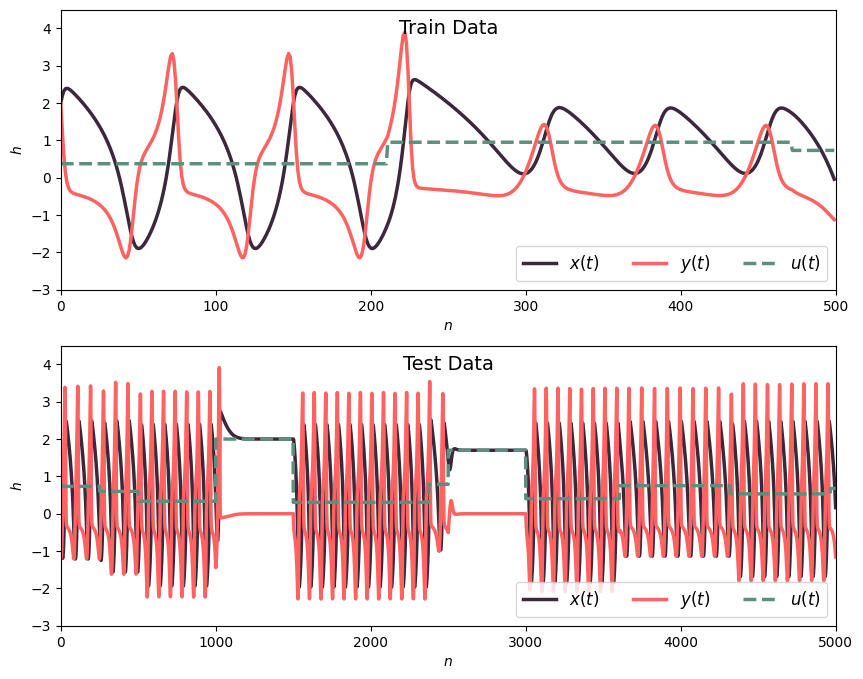

In [166]:
# ===============================================================
# Plot Training and Testing Regions
# ===============================================================

fig = plt.figure(figsize=(10, 8))
linewidth_tam = 2.5

plt.subplots_adjust(wspace=0.15, hspace=0.2)

# ---------------------------------------
# Subplot 1 — Training Region
# ---------------------------------------
sub1 = fig.add_subplot(2, 1, 1)
plt.annotate(
    "Train Data",
    xy=(train_data.shape[1] / 2, 4),
    va="center",
    ha="center",
    fontsize=14,
)

# Plot x(t) and y(t) from training data
sub1.plot(train_data[0, :], color="#3b283a", linewidth=linewidth_tam, label="$x(t)$")
sub1.plot(train_data[1, :], color="#ff6361", linewidth=linewidth_tam, label="$y(t)$")

# Plot input u(t)
sub1.plot(
    u_train[0, :],
    color="#5d8f7f",
    linestyle="--",
    linewidth=linewidth_tam,
    label="$u(t)$",
)

# Styling
sub1.set_xlim(0, train_data.shape[1])
sub1.set_ylim(-3.0, 4.5)
sub1.set_ylabel("$h$")
sub1.set_xlabel("$n$")
sub1.legend(ncol=3, fontsize="large", loc="lower right")

# ---------------------------------------
# Subplot 2 — Test Region
# ---------------------------------------
sub2 = fig.add_subplot(2, 1, 2)
plt.annotate(
    "Test Data", xy=(test_data.shape[1] / 2, 4), va="center", ha="center", fontsize=14
)

# Plot x(t) and y(t) from testing data
sub2.plot(test_data[0, :], color="#3b283a", linewidth=linewidth_tam, label="$x(t)$")
sub2.plot(test_data[1, :], color="#ff6361", linewidth=linewidth_tam, label="$y(t)$")

# Plot input u(t)
sub2.plot(
    u_test[0, :],
    color="#5d8f7f",
    linestyle="--",
    linewidth=linewidth_tam,
    label="$u(t)$",
)

# Styling
sub2.set_xlim(0, test_data.shape[1])
sub2.set_ylim(-3.0, 4.5)
sub2.set_ylabel("$h$")
sub2.set_xlabel("$n$")
sub2.legend(ncol=3, fontsize="large", loc="lower right")

# ---------------------------------------
# Save the figure
# ---------------------------------------
plt.savefig("train_test_data.jpg", format="jpg", dpi=300, bbox_inches="tight")


## ESN predictions output

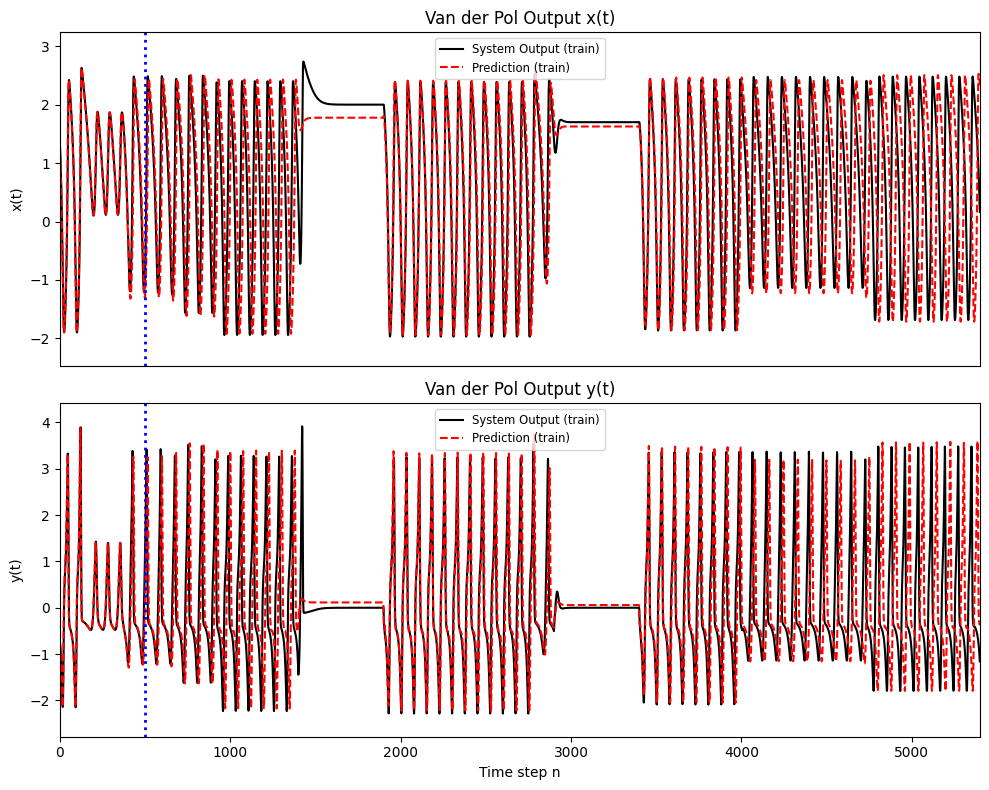

In [167]:
Y_train_pred = esn.Wout @ esn.X_train

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.25)


axes[0].plot(
    np.arange(train_data_predictions),
    train_data[0, warm_up:],
    color="black",
    linewidth=1.5,
    label="System Output (train)",
)
axes[0].plot(
    np.arange(train_data_predictions),
    Y_train_pred[0, :],
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="Prediction (train)",
)

axes[0].plot(
    np.arange(train_data_predictions, train_data_predictions + len(test_data[0, :])),
    test_data[0, :],
    color="black",
    linewidth=1.5,
)
axes[0].plot(
    np.arange(train_data_predictions, train_data_predictions + len(Y_pred[0, :])),
    Y_pred[0, :],
    color="red",
    linestyle="--",
    linewidth=1.5,
)

axes[0].axvline(train_size, linewidth=2, color="blue", linestyle="dotted")

axes[0].set_xlim(0, train_data_predictions + len(test_data[0, :]))
axes[0].set_ylim(
    min(train_data[0, warm_up:].min(), test_data[0, :].min()) - 0.5,
    max(train_data[0, warm_up:].max(), test_data[0, :].max()) + 0.5,
)
axes[0].set_ylabel("x(t)")
axes[0].set_title("Van der Pol Output x(t)")
axes[0].legend(loc="best", fontsize="small")
axes[0].set_xticks([])


axes[1].plot(
    np.arange(train_data_predictions),
    train_data[1, warm_up:],
    color="black",
    linewidth=1.5,
    label="System Output (train)",
)
axes[1].plot(
    np.arange(train_data_predictions),
    Y_train_pred[1, :],
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="Prediction (train)",
)

# Parte de teste
axes[1].plot(
    np.arange(train_data_predictions, train_data_predictions + len(test_data[1, :])),
    test_data[1, :],
    color="black",
    linewidth=1.5,
)
axes[1].plot(
    np.arange(train_data_predictions, train_data_predictions + len(Y_pred[1, :])),
    Y_pred[1, :],
    color="red",
    linestyle="--",
    linewidth=1.5,
)

axes[1].axvline(train_size, linewidth=2, color="blue", linestyle="dotted")

axes[1].set_xlim(0, train_size - warm_up + len(test_data[1, :]))
axes[1].set_ylim(
    min(train_data[1, warm_up:].min(), test_data[1, :].min()) - 0.5,
    max(train_data[1, warm_up:].max(), test_data[1, :].max()) + 0.5,
)
axes[1].set_ylabel("y(t)")
axes[1].set_xlabel("Time step n")
axes[1].set_title("Van der Pol Output y(t)")
axes[1].legend(loc="best", fontsize="small")


plt.tight_layout()
plt.savefig("esn_train_test_vanderpol.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.show()


## PI-ESN predictions output

In [ ]:
# --- Create two subplots: one for x (var 0), one for y (var 1)
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=("X Component", "Y Component"),
)

# --- X component (var 0)
fig.add_trace(
    go.Scatter(
        y=piesn.ESN.output_data_test[0, :],  # true system
        mode="lines",
        name="System (True)",
        line=dict(color="black", width=3),
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        y=piesn.ESN.output_predict[0, :],
        mode="lines",
        name="ESN Prediction",
        line=dict(color="red", width=3, dash="dash"),
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        y=piesn.output_prediction_PI[0, :],
        mode="lines",
        name="PI-ESN Prediction",
        line=dict(color="green", width=3),
    ),
    row=1,
    col=1,
)

# --- Y component (var 1)
fig.add_trace(
    go.Scatter(
        y=piesn.ESN.output_data_test[1, :],
        mode="lines",
        name="System (True)",
        line=dict(color="black", width=3),
        showlegend=False,  # avoid duplicate legend
    ),
    row=2,
    col=1,
)

fig.add_trace(
    go.Scatter(
        y=piesn.ESN.output_predict[1, :],
        mode="lines",
        name="ESN Prediction",
        line=dict(color="red", width=3, dash="dash"),
        showlegend=False,
    ),
    row=2,
    col=1,
)

fig.add_trace(
    go.Scatter(
        y=piesn.output_prediction_PI[1, :],
        mode="lines",
        name="PI-ESN Prediction",
        line=dict(color="green", width=3),
        showlegend=False,
    ),
    row=2,
    col=1,
)

# --- Layout adjustments ---
fig.update_layout(
    title="System vs ESN and PI-ESN Predictions",
    xaxis_title="Time step",
    yaxis_title="Output (X)",
    xaxis2_title="Time step",
    yaxis2_title="Output (Y)",
    template="plotly_white",
    legend=dict(
        x=1.02,  # legend on the right
        y=1,
        traceorder="normal",
        bgcolor="rgba(255,255,255,0)",
        bordercolor="rgba(0,0,0,0)",
    ),
)

fig.show(renderer="browser")
fig.write_html("system_vs_esn_piesn.html")

## Visualization of Reservoir States (X_train)

In [ ]:
def plot_esn_states(X, filename, initial_display=20):
    """
    Interactive Plotly plot of ESN states (X_train).
    """
    n_states = X.shape[0]
    n_time = X.shape[1]

    fig = go.Figure()

    for i in range(n_states):
        fig.add_trace(
            go.Scatter(
                x=np.arange(n_time),
                y=X[i, :],
                mode="lines",
                name=f"State {i}",
                visible=(i < initial_display),
            )
        )

    # --- Dropdown menu ---
    options_list = [5, 10, 20, 50, n_states]
    buttons = []

    for val in options_list:
        visible_list = [i < val for i in range(n_states)]
        buttons.append(
            dict(
                label=str(val),
                method="update",
                args=[
                    {"visible": visible_list},
                    {"title": f"Reservoir States - X_train (first {val} states)"},
                ],
            )
        )

    fig.update_layout(
        updatemenus=[
            dict(
                active=options_list.index(initial_display),
                buttons=buttons,
                x=1.15,
                y=1,
                xanchor="left",
                yanchor="top",
            )
        ],
        title=f"Reservoir States - {filename}",
        xaxis_title="Time Step",
        yaxis_title="State Value",
        width=1400,
        height=600,
        template="plotly_white",
    )

    fig.show(renderer="browser")
    fig.write_html(f"esn_states_{str(filename)}.html")


# ================= Example usage =================
plot_esn_states(esn.X_train, "X_train", initial_display=100)


## Visualization the evolution of the  States in PI-ESN and ESN (X_test)

In [ ]:
def plot_esn_states_comparison(X_esn, X_piesn, filename, initial_display=20):
    n_states, n_time = X_esn.shape

    fig = make_subplots(
        rows=3,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=("ESN - X_test", "PI-ESN - X_test", "Difference (PI-ESN - ESN)"),
    )

    for i in range(n_states):
        fig.add_trace(
            go.Scatter(
                x=np.arange(n_time),
                y=X_esn[i, :],
                mode="lines",
                name=f"State {i}" if i < 20 else None,
                legendgroup=f"State{i}",
                visible=(i < initial_display),
            ),
            row=1,
            col=1,
        )

        fig.add_trace(
            go.Scatter(
                x=np.arange(n_time),
                y=X_piesn[i, :],
                mode="lines",
                name=f"State {i}" if i < 20 else None,
                legendgroup=f"State{i}",
                showlegend=False,
                visible=(i < initial_display),
            ),
            row=2,
            col=1,
        )

        fig.add_trace(
            go.Scatter(
                x=np.arange(n_time),
                y=X_piesn[i, :] - X_esn[i, :],
                mode="lines",
                name=f"State {i}" if i < 20 else None,
                legendgroup=f"State{i}",
                showlegend=False,
                visible=(i < initial_display),
            ),
            row=3,
            col=1,
        )

    # --- Dropdown ---
    options_list = [5, 10, 20, 50, n_states]
    buttons = []
    for val in options_list:
        visible_list = []
        for i in range(n_states):
            show = i < val
            visible_list.extend([show] * 3)
        buttons.append(
            dict(
                label=str(val),
                method="update",
                args=[
                    {"visible": visible_list},
                    {"title": f"X_test Comparison (first {val} states)"},
                ],
            )
        )

    fig.update_layout(
        updatemenus=[
            dict(
                active=options_list.index(initial_display),
                buttons=buttons,
                x=1.15,
                y=1,
                xanchor="left",
                yanchor="top",
            )
        ],
        xaxis_title="Time Step",
        yaxis_title="State Value",
        template="plotly_white",
    )

    fig.show(renderer="browser")
    fig.write_html(f"esn_piesn_comparison_linked_{str(filename)}.html")


# ================= Example usage =================
plot_esn_states_comparison(
    esn.X_test, piesn.PI_ESN.X_test, "X_test", initial_display=100
)


## ESN weight matrices (Win, W, WQf)

In [ ]:
def plot_esn_heatmaps_highres(esn):
    """
    Plots ESN weight matrices (Win, Wf, W) as heatmaps.
    """

    weight_dict = {
        "Input Weights (Win)": esn.Win,
        "Feedback Weights (Wf)": esn.Wf,
        "Reservoir Weights (W)": esn.W,
    }

    # Create 1x3 subplots
    fig = make_subplots(
        rows=1,
        cols=3,
        subplot_titles=list(weight_dict.keys()),
        horizontal_spacing=0.05,
    )

    # Determine global vmin/vmax for consistent colorbar
    all_weights = []
    for W in weight_dict.values():
        if not isinstance(W, np.ndarray):
            W = W.detach().cpu().numpy()
        all_weights.append(W)
    global_vmin = np.percentile(np.concatenate([W.flatten() for W in all_weights]), 1)
    global_vmax = np.percentile(np.concatenate([W.flatten() for W in all_weights]), 99)

    for idx, (name, W) in enumerate(weight_dict.items()):
        if not isinstance(W, np.ndarray):
            W = W.detach().cpu().numpy()

        col = idx + 1

        # Add heatmap
        fig.add_trace(
            go.Heatmap(
                z=W,
                colorscale="RdBu",
                zmin=global_vmin,
                zmax=global_vmax,
                showscale=False,  # hide individual colorbars
            ),
            row=1,
            col=col,
        )

        # Automatic integer ticks
        max_x = W.shape[1] - 1
        max_y = W.shape[0] - 1
        step_x = max(1, max_x // 10)
        step_y = max(1, max_y // 5)

        fig.update_xaxes(title_text="Column (j)", tick0=0, dtick=step_x, row=1, col=col)
        fig.update_yaxes(title_text="Row (i)", tick0=0, dtick=step_y, row=1, col=col)

    # Add **single shared colorbar** on the right
    fig.add_trace(
        go.Heatmap(
            z=np.array([[global_vmin, global_vmax]]),  # dummy heatmap for colorbar
            colorscale="RdBu",
            showscale=True,
            colorbar=dict(title="Weight Value", len=0.8, y=0.5),
        ),
        row=1,
        col=3,
    )

    fig.update_layout(
        title="ESN Weight Matrices", width=1800, height=600, template="plotly_white"
    )

    fig.show(renderer="browser")
    fig.write_html("esn_weights.html")


# ================= Example usage =================
plot_esn_heatmaps_highres(esn)


## Analysis of Wout: ESN vs PI-ESN

In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def plot_Wout_heatmaps_scatter(esn, piesn):
    Wout_esn = esn.Wout
    Wout_piesn = piesn.PI_ESN.Wout
    Wout_diff = Wout_esn - Wout_piesn

    heatmaps_dict = {
        "Wout ESN": Wout_esn,
        "Wout PI-ESN": Wout_piesn,
        "Difference (ESN - PI-ESN)": Wout_diff,
    }

    fig = make_subplots(
        rows=2,
        cols=3,
        specs=[[{}, {}, {}], [{"colspan": 3}, None, None]],
        subplot_titles=list(heatmaps_dict.keys()) + ["Wout ESN vs Wout PI-ESN"],
        vertical_spacing=0.15,
        row_heights=[0.6, 0.4],
        horizontal_spacing=0.05,
    )

    global_vmin = min(np.min(Wout_esn), np.min(Wout_piesn))
    global_vmax = max(np.max(Wout_esn), np.max(Wout_piesn))

    for idx, (name, W) in enumerate(heatmaps_dict.items()):
        col = idx + 1

        if "Difference" in name:
            zmin, zmax = np.min(W), np.max(W)
            showscale = True
            colorbar_dict = dict(title="Weight Value", len=0.4, y=0.75, thickness=15)
        else:
            zmin, zmax = global_vmin, global_vmax
            showscale = False
            colorbar_dict = None

        fig.add_trace(
            go.Heatmap(
                z=W,
                colorscale="RdBu_r",
                zmin=zmin,
                zmax=zmax,
                showscale=showscale,
                colorbar=colorbar_dict,
                hovertemplate="%{z:.5f}<extra></extra>",
            ),
            row=1,
            col=col,
        )

        max_x, max_y = W.shape[1] - 1, W.shape[0] - 1
        fig.update_xaxes(
            title_text="Column (j)", tick0=0, dtick=max(1, max_x // 10), row=1, col=col
        )
        fig.update_yaxes(
            title_text="Row (i)", tick0=0, dtick=max(1, max_y // 5), row=1, col=col
        )

    scatter_dict = {"Wout ESN": Wout_esn, "Wout PI-ESN": Wout_piesn}
    scatter_colors = ["blue", "red"]

    for i, (name, W) in enumerate(scatter_dict.items()):
        fig.add_trace(
            go.Scatter(
                x=np.arange(W.size),
                y=W.flatten(),
                mode="markers",
                marker=dict(color=scatter_colors[i], size=5),
                name=name,
                hovertemplate="%{y:.5f}<extra></extra>",
            ),
            row=2,
            col=1,
        )

    fig.update_xaxes(title_text="Element index", row=2, col=1)
    fig.update_yaxes(title_text="Weight value", row=2, col=1)

    fig.update_layout(
        title="Wout ESN vs PI-ESN",
        width=1800,
        height=900,
        template="plotly_white",
        legend=dict(
            x=1.02,
            y=0.3,
            traceorder="normal",
            font=dict(size=12),
            bordercolor="Black",
            borderwidth=1,
        ),
    )

    fig.show(renderer="browser")
    fig.write_html("Wout_heatmaps_scatter.html")


plot_Wout_heatmaps_scatter(esn, piesn)